## Variational Autoencoder (VAE) 

Based on the [paper](https://arxiv.org/abs/1312.6114) and the original variational autoencoder network using [tensorflow_probability](https://github.com/tensorflow/probability).

![variational autoencoder](https://raw.githubusercontent.com/timsainb/tensorflow2-generative-models/master/imgs/vae.png)


### Load packages

In [ ]:
# !pip install tfp-nightly==0.9.0-dev20191008
# !pip install tensorflow==2.0.0

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

# the nightly build of tensorflow_probability is required as of the time of writing this 
import tensorflow_probability as tfp
ds = tfp.distributions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [ ]:
print(tf.__version__, tfp.__version__)

2.0.0 0.9.0-dev20191008


### Create a fashion-MNIST dataset

In [ ]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [ ]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

### Define the network as tf.keras.model object

In [ ]:
class VAE(tf.keras.Model):
    """a basic vae class for tensorflow
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(VAE, self).__init__()
        self.__dict__.update(kwargs)

        self.enc = tf.keras.Sequential(self.enc)
        self.dec = tf.keras.Sequential(self.dec)

    def encode(self, x):
        mu, sigma = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def reconstruct(self, x):
        mu, _ = tf.split(self.enc(x), num_or_size_splits=2, axis=1)
        return self.decode(mu)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(self, x):

        q_z = self.encode(x)
        z = q_z.sample()
        x_recon = self.decode(z)
        p_z = ds.MultivariateNormalDiag(
          loc=[0.] * z.shape[-1], scale_diag=[1.] * z.shape[-1]
          )
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0))
        recon_loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(x - x_recon), axis=0))

        return recon_loss, latent_loss

    def compute_gradients(self, x):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        return tape.gradient(loss, self.trainable_variables)

    @tf.function
    def train(self, train_x):
        gradients = self.compute_gradients(train_x)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

### Define the network architecture

In [ ]:
N_Z = 2
encoder = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=N_Z*2),
]

decoder = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

### Create Model

In [ ]:
# the optimizer for the model
optimizer = tf.keras.optimizers.Adam(1e-3)
# train the model
model = VAE(
    enc = encoder,
    dec = decoder,
    optimizer = optimizer,
)

### Train the model

In [ ]:
# exampled data for plotting results
example_data = next(iter(test_dataset))


def plot_reconstruction(model, example_data, nex=8, zm=2):

    example_data_reconstructed = model.reconstruct(example_data)
    samples = model.decode(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=3, figsize=(zm * nex, zm * 3))
    for axi, (dat, lab) in enumerate(
        zip(
            [example_data, example_data_reconstructed, samples],
            ["data", "data recon", "samples"],
        )
    ):
        for ex in range(nex):
            axs[axi, ex].matshow(
                dat.numpy()[ex].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
            )
            axs[axi, ex].axes.get_xaxis().set_ticks([])
            axs[axi, ex].axes.get_yaxis().set_ticks([])
        axs[axi, 0].set_ylabel(lab)

    plt.show()

In [ ]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['recon_loss', 'latent_loss'])

Epoch: 49 | recon_loss: 16.61134910583496 | latent_loss: 4.0243000984191895


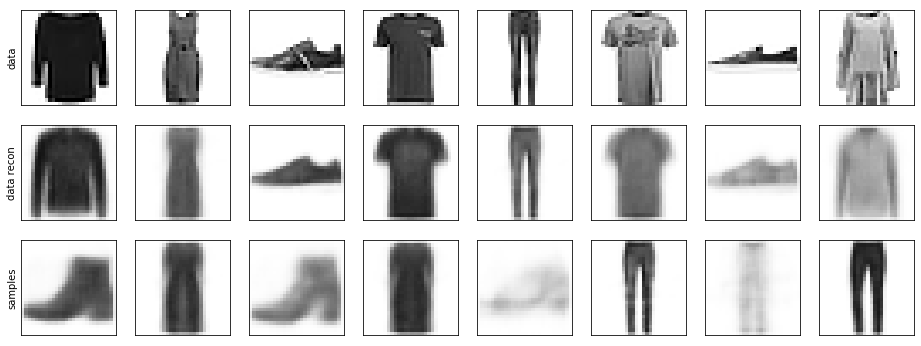

In [ ]:
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | recon_loss: {} | latent_loss: {}".format(
            epoch, losses.recon_loss.values[-1], losses.latent_loss.values[-1]
        )
    )
    plot_reconstruction(model, example_data)

### Show grid in 2D latent space


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(-0.5, 279.5, 279.5, -0.5)

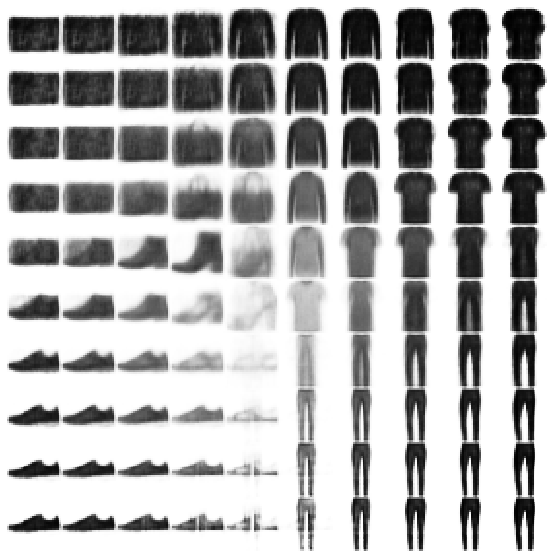

In [ ]:
# sample from grid
nx = ny =10
meshgrid = np.meshgrid(np.linspace(-3, 3, nx), np.linspace(-3, 3, ny))
meshgrid = np.array(meshgrid).reshape(2, nx*ny).T
x_grid = model.decode(meshgrid)
x_grid = x_grid.numpy().reshape(nx, ny, 28,28, 1)
# fill canvas
canvas = np.zeros((nx*28, ny*28))
for xi in range(nx):
    for yi in range(ny):
        canvas[xi*28:xi*28+28, yi*28:yi*28+28] = x_grid[xi, yi,:,:,:].squeeze()
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(canvas, cmap=plt.cm.Greys)
ax.axis('off')